In [1]:
from matplotlib import pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd
import h5py
import os.path
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils
from keras import optimizers

In [3]:
# 센서 1만 데이터 불러오기_ 셔플 시도
# h5 데이터는 이 파일과 같은 폴더에 있어야 함... 죄송함댜ㅎㅎ
Label_size = 32
#sensor1_data = np.empty((0,765+Label_size),int)
sensor1_data = np.empty((0,765),int)
sensor1_label = np.empty((0,Label_size),int)
position_label = np.empty((0,Label_size),int)
label_cnt = 0
sensor1_data_training = np.empty((0,765+Label_size),int)
sensor1_data_test = np.empty((0,765+Label_size),int)
print(position_label)
for ii in range(12346):
#for ii in range(2):
    filename ='20201022_Depth_{}.h5'.format(ii)
    
    if os.path.isfile(filename):
        h5f = h5py.File(filename,'r')
        a_dset_keys = list(h5f.keys())
        ds_data = h5f[a_dset_keys[0]]
        sensor1 = ds_data[:,0,:]    
        
        sensor1 = np.array(sensor1)
        
        #Scale down_ 10분의 1
        sensor1 = sensor1[0::10]
        #sensor1 = sensor1[0::5]
        
        #print("Sensor1_data:", sensor1.shape)
        #print("Scale_down_data:", scale_down_sensor1.shape)
        
        #전체 데이터 예시
        #########################################################################################################
        position_label = np.zeros((sensor1.shape[0],Label_size))
        #position_label = np.ones((sensor1.shape[0],Label_size))

        #32bit coding
        if(ii == 0):
            aa = 1
        else:
            position_label[:,label_cnt] = 1
        label_cnt += 1
         
        sensor1_data= np.append(sensor1_data,sensor1,axis = 0)
        sensor1_label = np.append(sensor1_label,position_label,axis =0)
        
        print("{} done".format(ii))
    else:
        a = 1
        

sensor1_data.shape
sensor1_label.shape

[]
0 done
1 done
2 done
3 done
4 done
5 done
12 done
13 done
14 done
15 done
23 done
24 done
25 done
34 done
35 done
45 done
123 done
124 done
125 done
134 done
135 done
145 done
234 done
235 done
245 done
345 done
1234 done
1235 done
1245 done
1345 done
2345 done
12345 done


(7364, 32)

In [9]:
sc = preprocessing.StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(sensor1_data, sensor1_label, test_size=0.2, shuffle=True, stratify=sensor1_label, random_state=34)

#Scaling
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#CNN 모델 적용을 위한 reshape
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print("X_train:",X_train.shape)
print("X_test",X_test.shape)
print("Y_train",y_train.shape)
print("Y_test",y_test.shape)

X_train: (5891, 765, 1)
X_test (1473, 765, 1)
Y_train (5891, 32)
Y_test (1473, 32)


In [10]:
#KM CNN모델
#CNN모델
model_m = Sequential()
model_m.add(Conv1D(64, 5, activation='relu',input_shape=(765,1)))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(64, 5, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(64, 5, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Dropout(0.3))
model_m.add(Conv1D(64, 5, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(128, 5, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Flatten())
model_m.add(Dense(128, activation = 'relu'))
#과대적합 발생 시, Dropout 추가
model_m.add(Dropout(0.3))
model_m.add(Dense(32, activation='softmax'))
print(model_m.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 761, 64)           384       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 380, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 376, 64)           20544     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 188, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 184, 64)           20544     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 92, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 92, 64)           

In [11]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
#callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
###sgd
#sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
#model_m.compile(loss='categorical_crossentropy',
#                optimizer=sgd, metrics=['accuracy'])
adam = optimizers.Adam(lr = 0.00001)
#adam = optimizers.Adam()
model_m.compile(loss='categorical_crossentropy',
                optimizer=adam, metrics=['accuracy'])

    
history = model_m.fit(X_train,
                      y_train,
                      batch_size=30,
                      epochs=5,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/5
158/158 [==============================] - 20s 128ms/step - loss: 3.4181 - accuracy: 0.0980 - val_loss: 3.3970 - val_accuracy: 0.2570
Epoch 2/5
158/158 [==============================] - 19s 121ms/step - loss: 3.1689 - accuracy: 0.2823 - val_loss: 2.9589 - val_accuracy: 0.5250
Epoch 3/5
158/158 [==============================] - 18s 115ms/step - loss: 2.2460 - accuracy: 0.4546 - val_loss: 1.7479 - val_accuracy: 0.6777
Epoch 4/5
158/158 [==============================] - 16s 102ms/step - loss: 1.2706 - accuracy: 0.6562 - val_loss: 0.8726 - val_accuracy: 0.9025
Epoch 5/5
158/158 [==============================] - 16s 104ms/step - loss: 0.7438 - accuracy: 0.7878 - val_loss: 0.4594 - val_accuracy: 0.9754


In [12]:
def show_results(y_test, y_pred):
    max_y_pred_test = np.argmax(y_pred, axis=1)
    max_y_test = np.argmax(y_test, axis=1)
    #show_confusion_matrix(max_y_test, max_y_pred_test)
    print(classification_report(max_y_test, max_y_pred_test))
    

In [13]:
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.90      1.00      0.95        66
           2       0.98      1.00      0.99        61
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        57
           5       1.00      1.00      1.00        83
           6       1.00      1.00      1.00        32
           7       1.00      1.00      1.00        61
           8       1.00      1.00      1.00        59
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        51
          12       1.00      1.00      1.00        42
          13       1.00      1.00      1.00        33
          14       1.00      1.00      1.00        25
          15       1.00      1.00      1.00        23
          16       1.00      1.00      1.00        56
          17       1.00    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
a = np.argmax(y_test, axis =1)
b = np.argmax(y_pred,axis = 1)
b.shape
a.shape

(1473,)

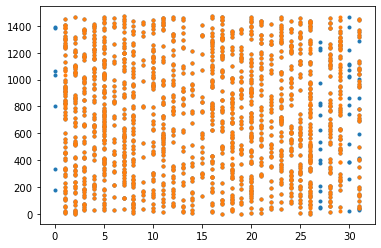

In [18]:
x = np.arange(len(a))
plt.plot(a,x,'.',label ='y_test')
plt.plot(b,x,'.', label='y_pred')

Text(0.5, 1.0, 'Training(--) and validation loss')

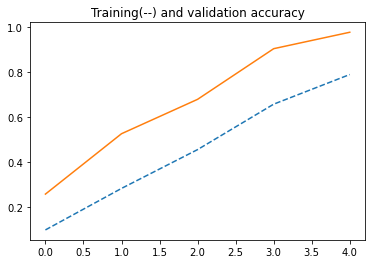

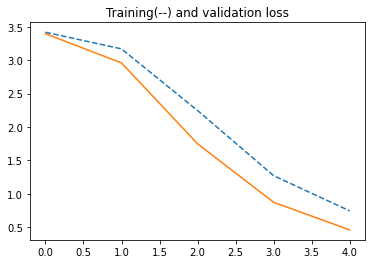

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')